In [1]:
import os

import numpy as np
import pandas as pd
from bs4.diagnose import diagnose
from sqlalchemy import create_engine

import openmimic as om
from openmimic import attach_icustay_id, move_column

# db configuration
username = 'root'
password = os.getenv('AIMED_PW')
host = '172.28.8.103'
port = '3306'
database = "MIMIC_III"
db_engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# om configuration
om.Config.mimic_path = "../mimic3_csv/"

# path configuration
processed_tables_path = "./processed_tables/"
experiment_data = "./experiment_data/"

In [17]:
import importlib


def reload_all():
    importlib.reload(om)
    importlib.reload(om.chartevents)
    importlib.reload(om.chartevents_engineering)
    # importlib.reload(om.cohort)
    importlib.reload(om.config)
    importlib.reload(om.utils)
    importlib.reload(om.inputevents_mv)
    importlib.reload(om.inputevents_mv_engineering)
    importlib.reload(om.mimic_preprocessor)
    importlib.reload(om.patient_static)
    importlib.reload(om.patient_static_engineering)
    importlib.reload(om.outputevents)
    importlib.reload(om.outputevents_engineering)
    importlib.reload(om.labevents)
    importlib.reload(om.labevents_engineering)


reload_all()

# Patient_static

In [2]:
query = "SELECT * FROM patient_static"
patients_all = pd.read_sql(query, db_engine)

patients_static = om.PatientStatic()
patients_static.load(patients_all)
# patients_static.patients_T_info

# load processed
# patients_static = om.PatientStatic()
# patients_static_csv = pd.read_csv(processed_tables_path + "p_patients_static.csv")
# patients_static_T_info_csv = pd.read_csv(processed_tables_path + "p_patients_static_T_info.csv")
# patients_static.load_processed(patients_static_csv, patients_static_T_info_csv)

-> make_patients_T_info...	 Complete!	18.36s


In [9]:
patients_all.to_csv("custom_patients_static.csv")

# Chartevents

In [2]:
chartevents_items_from_mimic_extract = {
    769, 220644, 772, 1521, 227456, 773, 225612, 227073, 770, 220587, 227443, 848, 225690, 1538, 225651, 803, 781, 1162,
    225624, 225625, 786, 1522, 816, 225667, 116, 89, 90, 220074, 113, 220602, 226536, 1523, 788, 789, 1524, 220603, 787,
    857, 225698, 777, 223679, 791, 1525, 220615, 224643, 225310, 220180, 8555, 220051, 8368, 8441, 8440, 227468, 1528,
    806,
    189, 727, 223835, 190, 198, 220621, 225664, 811, 807, 226537, 1529, 211, 220045, 226707, 226730, 1394, 813, 220545,
    220228, 814, 818, 225668, 1531, 220635, 1532, 821, 456, 220181, 224, 225312, 220052, 52, 6702, 224322, 646, 834,
    220277,
    220227, 226062, 778, 220235, 779, 227466, 825, 1533, 535, 224695, 860, 223830, 1126, 780, 220274, 1534, 225677, 827,
    224696, 543, 828, 227457, 224700, 506, 220339, 512, 829, 1535, 227464, 227442, 227467, 1530, 815, 1286, 824, 227465,
    491, 492, 220059, 504, 833, 224422, 618, 220210, 224689, 614, 651, 224690, 615, 224688, 619, 837, 1536, 220645,
    226534,
    626, 442, 227243, 224167, 220179, 225309, 6701, 220050, 51, 455, 223761, 677, 676, 679, 678, 223762, 224685, 682,
    224684, 683, 684, 224686, 1539, 849, 851, 227429, 859, 226531, 763, 224639, 226512, 861, 1542, 220546, 1127}
chartevents_items_from_fiddle = {220045, 220210, 224690, 224167, 227243, 220050, 220179, 225309, 223761, 223762, 224643, 227242, 220051, 220180, 225310, 220277, 226707, 226730, 224639, 226512, 226531}
chartevents_items = tuple(chartevents_items_from_mimic_extract.union(chartevents_items_from_fiddle))

query = f"SELECT * FROM CHARTEVENTS WHERE ITEMID IN {chartevents_items} ORDER BY CHARTTIME;"
chartevents_raw = pd.read_sql(query, db_engine)

In [3]:
chartevents_raw = pd.read_csv(processed_tables_path + "raw_chartevents.csv")
chartevents_raw["CHARTTIME"] = pd.to_datetime(chartevents_raw["CHARTTIME"])
chartevents_raw["ICUSTAY_ID"].unique()

KeyboardInterrupt: 

In [4]:
chartevents = om.Chartevents()
chartevents.load(chartevents_raw, patients_static.patients_T_info)
chartevents.process()

../mimic3_csv/
Chartevents data updated!
-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	1.20s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	2.33s
-> filter_remove_error...	 Complete!	1.82s
-> filter_remove_labitems...	../mimic3_csv/
 Complete!	1.25s
Chartevents data updated!
=> Before: 66,635,422, After: 66,534,355 : 99.85% remained.
Filtering Complete!
-----------------------------------
Processing...
-> process_group_variables_from_fiddle...	 Complete!	20.60s
Chartevents data updated!
-> process_aggregator...	 Complete!	6m 25.68s
-> process_interval_shift_alignment...	 Complete!	4.50s
Processing Complete!


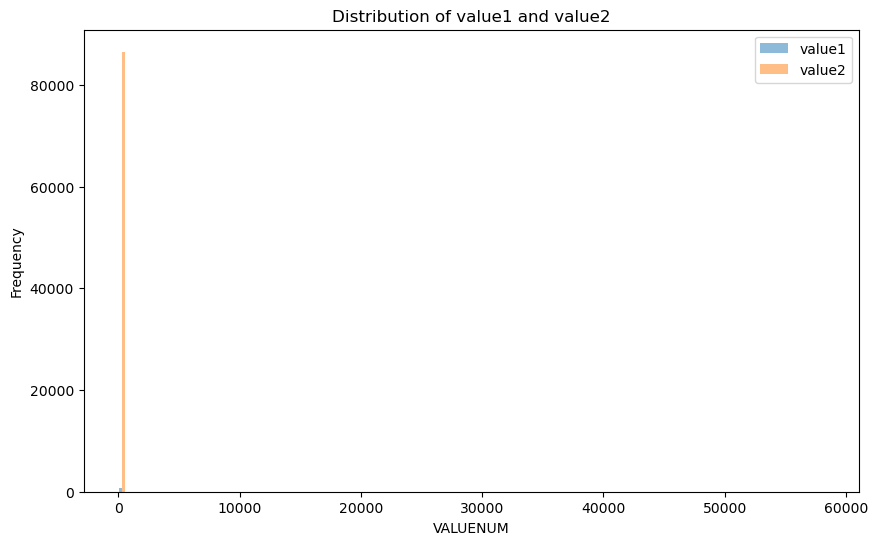

In [11]:
import matplotlib.pyplot as plt

# draw distribution
value1 = chartevents_raw.loc[chartevents_raw["ITEMID"].isin([224643]), "VALUENUM"]
value2 = chartevents_raw.loc[chartevents_raw["ITEMID"].isin([225310]), "VALUENUM"]


value1_clean = value1.dropna()
value2_clean = value2.dropna()

plt.figure(figsize=(10, 6))
plt.hist([value1_clean, value2_clean], bins=100, label=['value1', 'value2'], alpha=0.5)

plt.xlabel('VALUENUM')
plt.ylabel('Frequency')
plt.title('Distribution of value1 and value2')
plt.legend()
plt.show()




In [13]:
value1.describe()

count    671.000000
mean      65.092399
std       16.184951
min      -13.000000
25%       55.000000
50%       64.000000
75%       74.000000
max      139.000000
Name: VALUENUM, dtype: float64

In [14]:
value2.describe()

count    86507.000000
mean        59.989781
std        200.748193
min        -12.000000
25%         50.000000
50%         58.000000
75%         67.000000
max      58196.000000
Name: VALUENUM, dtype: float64

# Inputevents_MV

In [4]:
columns = "ROW_ID, ICUSTAY_ID, STARTTIME, ENDTIME, ITEMID, AMOUNT, AMOUNTUOM, RATE, RATEUOM, PATIENTWEIGHT"
columns = "*"
query = f"SELECT {columns} FROM INPUTEVENTS_MV"
inputevents_mv_raw = pd.read_sql(query, db_engine)

In [5]:
inputevents_mv = om.InputeventsMV()
inputevents_mv.load(inputevents_mv_raw, patients_static.patients_T_info)
inputevents_mv.process()

-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	0.26s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	0.34s
-> filter_remove_error...	 Complete!	0.63s
-> filter_remove_zero_input...	 Complete!	0.58s
-> filter_remove_continuous_uom_missing...	 Complete!	0.69s
=> Before: 3,618,991, After: 2,535,497 : 70.06% remained.
Filtering Complete!
-----------------------------------
Processing...
-> process_rateuom_into_hour_unit...	 Complete!	3.02s
-> process_unite_convertable_uom_by_D_ITEMS...	 Complete!	4.57s
-> process_split_ITEMID_by_unit...	 Complete!	3.49s
-> process_transform_T_cohort...	 Complete!	4m 8.95s
Processing Complete!


# Outputevents

In [7]:
columns = "*"
query = f"SELECT {columns} FROM OUTPUTEVENTS"
outputevents_raw = pd.read_sql(query, db_engine)

In [8]:
outputevents = om.Outputevents()
outputevents.load(outputevents_raw, patients_static.patients_T_info)
outputevents.process()

-----------------------------------
Filtering...
-> filter_remove_unassociated_columns...	 Complete!	0.08s
-> filter_remove_no_ICUSTAY_ID...	 Complete!	0.14s
-> filter_remove_error...	 Complete!	0.07s
-> filter_remove_zero_value...	 Complete!	0.11s
Outputevents data updated!
Filtering Complete!
=> Before: 4,349,218, After: 4,046,702 : 93.04% remained.
-----------------------------------
Processing...
-> process_aggregator...	 Complete!	2m 19.78s
-> process_interval_shift_alignment...	 Complete!	17.39s
Processing Complete!


# Labevents

In [3]:
columns = "*"
query = f"SELECT {columns} FROM LABEVENTS"
labevents_raw = pd.read_sql(query, db_engine)

In [4]:
query = f"SELECT * FROM ICUSTAYS"
icustay_raw = pd.read_sql(query, db_engine)

In [44]:
labevents = om.Labevents()
labevents.load(labevents_raw, patients_static.patients_T_info)
labevents.attach_icustay_id(icustay_raw)
labevents.filter()
labevents.process()

# Diagnoses_ICD

In [54]:
import pickle
import pandas as pd

medGAN_path = "../SyntheticEHR_Generation/1_real_data/medGAN_preprocessing/"
data = pickle.load(open(f"{medGAN_path}medGAN_binary_dataset.matrix", "rb"))
pids = pickle.load(open(f"{medGAN_path}medGAN_binary_dataset.pids", "rb"))
types = pickle.load(open(f"{medGAN_path}medGAN_binary_dataset.types", "rb"))
dataframe = pd.DataFrame(data, columns=types.keys())
dataframe.insert(0, "SUBJECT_ID", pids)

cohort_pids = np.load("./experiment_data/real_IN_HOSPITALITY_MORTALITY_pids.npy")
cohort_pids = pd.DataFrame(cohort_pids, columns=["SUBJECT_ID", "ICUSTAY_ID"])

icd_info = pd.merge(cohort_pids, dataframe, on="SUBJECT_ID", how="left")
icd_info.iloc[:, 2:].to_csv("./experiment_data/real_IN_HOSPITALITY_MORTALITY_icd.csv", index=False)

In [56]:
icd_info

,SUBJECT_ID,ICUSTAY_ID,D_967,D_969,D_E950,D_348,D_296,D_401,D_414,D_411,...,D_E975,D_179,D_393,D_657,D_V91,D_E827,D_915,D_387,D_E856,D_V78
0,3.0,211552.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,294638.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,228232.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,220597.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.0,229441.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38507,99985.0,279638.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38508,99991.0,226241.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38509,99992.0,242052.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38510,99995.0,229633.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
pd.read_csv("./experiment_data/real_IN_HOSPITALITY_MORTALITY_samples.csv")

,ICUSTAY_ID,T,SUBJECT_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,LOS,FIRST_CAREUNIT,FIRST_WARDID,...,"Bicarbonate, Pleural","Urine Crystals, Other",Myelocytes_4,Blood Parasite Smear,Factor XII,"Reticulocyte Count, Absolute","LD, Joint Fluid",CD34,Alpha Antiplasmin,"Creatinine, Joint Fluid"
0,200003,0.0,27513,48.3260,M,EMERGENCY,PHYS REFERRAL/NORMAL DELI,5.8884,SICU,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200003,1.0,27513,48.3260,M,EMERGENCY,PHYS REFERRAL/NORMAL DELI,5.8884,SICU,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200003,2.0,27513,48.3260,M,EMERGENCY,PHYS REFERRAL/NORMAL DELI,5.8884,SICU,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200003,3.0,27513,48.3260,M,EMERGENCY,PHYS REFERRAL/NORMAL DELI,5.8884,SICU,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200003,4.0,27513,48.3260,M,EMERGENCY,PHYS REFERRAL/NORMAL DELI,5.8884,SICU,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200068,25.0,17145,76.0521,M,EMERGENCY,EMERGENCY ROOM ADMIT,2.6366,MICU,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,200068,26.0,17145,76.0521,M,EMERGENCY,EMERGENCY ROOM ADMIT,2.6366,MICU,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,200068,27.0,17145,76.0521,M,EMERGENCY,EMERGENCY ROOM ADMIT,2.6366,MICU,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,200068,28.0,17145,76.0521,M,EMERGENCY,EMERGENCY ROOM ADMIT,2.6366,MICU,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cohort Integration


In [2]:
patients_static_csv = pd.read_csv(processed_tables_path + "p_patients_static.csv")
patients_static_T_info_csv = pd.read_csv(processed_tables_path + "p_patients_static_T_info.csv")
chartevents = pd.read_csv(processed_tables_path + "p_chartevents.csv")
inputevents_mv = pd.read_csv(processed_tables_path + "p_inputevents_mv.csv")
outputevents = pd.read_csv(processed_tables_path + "p_outputevents.csv")
labevents = pd.read_csv(processed_tables_path + "p_labevents.csv")

patients_static = om.PatientStatic()
patients_static.load_processed(patients_static_csv, patients_static_T_info_csv)
chartevents = om.Chartevents().load_processed(chartevents)
inputevents_mv = om.InputeventsMV().load_processed(inputevents_mv)
outputevents = om.Outputevents().load_processed(outputevents)
labevents = om.Labevents().load_processed(labevents, patients_static.patients_T_info)


KeyboardInterrupt



In [3]:
cohort = om.Cohort(patients_static, chartevents, inputevents_mv, outputevents, labevents)
del patients_static, chartevents, inputevents_mv, outputevents, labevents
cohort.make_cohort()

------convert column--------
-> remove_statics_tag...	 Complete!	0.00s
-> map_item_name...	 Complete!	0.00s
-> map_item_name_with_various_uom_columns...	 Complete!	0.00s
-> remove_statics_tag...	 Complete!	0.00s
-> map_item_name...	 Complete!	0.00s
-> remove_statics_tag...	 Complete!	0.00s
-> map_item_name...	 Complete!	0.00s
------------------------------
Baking Cohort... Done.
Tables merged: ['patients_static', 'chartevents', 'inputevents_mv', 'outputevents', 'labevents']


,ICUSTAY_ID,T,SUBJECT_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,LOS,FIRST_CAREUNIT,FIRST_WARDID,...,Basophils,Alpha Antiplasmin,"Cholesterol, Body Fluid",Myelocytes,Hypochromia,"Miscellaneous, CSF","Urine Crystals, Other","Prot. Electrophoresis, Urine",Promyelocytes,in_hospitality_mortality_label
1680923,200001,0.0,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,3.0786,MICU,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680924,200001,1.0,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,3.0786,MICU,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680925,200001,2.0,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,3.0786,MICU,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680926,200001,3.0,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,3.0786,MICU,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1680927,200001,4.0,55973,61.1096,F,EMERGENCY,CLINIC REFERRAL/PREMATURE,3.0786,MICU,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347284,299999,25.0,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,1.2978,CSRU,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
347285,299999,26.0,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,1.2978,CSRU,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
347286,299999,27.0,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,1.2978,CSRU,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
347287,299999,28.0,7630,48.7644,M,ELECTIVE,PHYS REFERRAL/NORMAL DELI,1.2978,CSRU,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [26]:
features, label = cohort.make_train_set()
# features.to_csv(processed_data_path+"mimic_features.csv")
# label.to_csv(processed_data_path+"mimic_label.csv")

In [11]:
df = pd.read_csv(processed_tables_path + "cohort.csv", index_col=0)
cohort = om.Cohort(cohort=df)

/tmp/ipykernel_2501554/2820402200.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(processed_data_path+"cohort.csv", index_col=0)


In [12]:
cohort.data

,SUBJECT_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,ICUSTAY_ID,LOS,FIRST_CAREUNIT,FIRST_WARDID,HADM_to_ICU_time,...,Replete (2/3) (0),Imipenem/Cilastatin (1),Boost Glucose Control (3/4) (0),Resource Fruit Beverage (0),Mighty Shake (no sugar added) (0),Nutren 2.0 (3/4) (0),Keflex (1),Quinine (0),Lansoprazole (Prevacid) (1),label
0,2,0.0000,M,NEWBORN,PHYS REFERRAL/NORMAL DELI,243653,0.0918,NICU,56,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,0.0000,M,NEWBORN,PHYS REFERRAL/NORMAL DELI,243653,0.0918,NICU,56,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,76.5753,M,EMERGENCY,EMERGENCY ROOM ADMIT,211552,6.0646,MICU,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,76.5753,M,EMERGENCY,EMERGENCY ROOM ADMIT,211552,6.0646,MICU,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3,76.5753,M,EMERGENCY,EMERGENCY ROOM ADMIT,211552,6.0646,MICU,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239467,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239468,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239469,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2239470,99999,64.0247,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,246512,1.1242,SICU,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
id = 200001
patients_static.patients_T_info[patients_static.patients_T_info["ICUSTAY_ID"] == id]["T"].max(), \
    chartevents.processed_result[chartevents.processed_result["ICUSTAY_ID"] == id]["T"].max(), \
    inputevents_mv.processed_result[inputevents_mv.processed_result["ICUSTAY_ID"] == id]["T"].max(), \
    outputevents.processed_result[outputevents.processed_result["ICUSTAY_ID"] == id]["T"].max()

(47, 45.0, 44, 26)

In [ ]:
import pandas as pd

# make samples dataframe with sample column and data

samples = pd.DataFrame({
    "a": [1, 2, 3, 4, 5],
    "b": ["a", "b", "c", "d", "e"]
})

samples

In [ ]:
print("asdf")